In [328]:
import warnings
warnings.filterwarnings("ignore")

In [329]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [330]:
%matplotlib inline
plt.style.use('bmh')

In [331]:
# self created packages
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.visualizations import Visualization
from scripts.snowflake_sink import SnowflakeConnector

In [332]:
# pyspark packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, desc, explode, split, year, month, dayofweek, length, initcap, trim, lower, 
    regexp_extract, regexp_replace, max, explode, count, when, concat_ws)
from pyspark.sql.types import (
    StructType, StructField, IntegerType, StringType,
    FloatType, BooleanType, DateType, DoubleType)

# pyspakr ML library
from pyspark.ml.feature import VectorAssembler, ChiSqSelector, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

In [333]:
spark = SparkSession.builder \
    .appName("Data Modeling") \
    .getOrCreate()

spark

In [334]:
ip_data = spark.read.option("header", "True") \
                .option("inferSchema", "True") \
                .option("quote", '"') \
                .option("escape", '"') \
                .option("sep", ",") \
                .option("ignoreLeadingWhiteSpace", "True") \
                .option("ignoreTrailingWhiteSpace", "True") \
                .option("multiLine", "True") \
                .option("mode", "PERMISSIVE") \
                .csv("../data/gun_violence_cleaned_data_2013_2018.csv")

print(f"Number of records in the data : {ip_data.count()}")
print(f"Number of columns: {len(ip_data.columns)}")

Number of records in the data : 239677
Number of columns: 45


In [335]:
txt_columns = ["notes"]

ip_data = ip_data.fillna("missing", subset=txt_columns)

### Classification (without the text column)

For startes we are setting the target column as `is_killed` a new column created and proceed with the classification problem.

We will also drop features such as `incident_id`, `notes`, `date`, `city_or_county`, and may be `incident_characteristics`, `year`

Not sure if `year` is needed as it might be missleading.

In [337]:
class_ip_data = ip_data.withColumn("is_killed", when(col("n_killed") > 0, 1).otherwise(0))

Dropping columns which we won't be using.

In [339]:
cols_to_drop = ["n_killed", "incident_id", "date", "address", "congressional_district", 
                "incident_characteristics", "latitude", "longitude", "notes", "city_or_county",
                "participant_status_injured_freq", "participant_status_killed_freq", "participant_status_arrested_freq",
                "participant_status_unharmed_freq", "participant_type_subject_suspect_freq", "participant_type_victim_freq"]

class_ip_data = class_ip_data.drop(*cols_to_drop)

In [340]:
non_numeric_columns = [field.name for field in class_ip_data.schema.fields if not isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]

print("Non-integer and non-float columns:", non_numeric_columns)

Non-integer and non-float columns: ['state']


In [341]:
def encode_multiple_columns_with_string_indexer(df, columns):
    """
    Function to encode multiple columns using StringIndexer.
    
    Parameters:
    df (DataFrame): The input DataFrame.
    columns (list): List of column names to be indexed.
    
    Returns:
    DataFrame: DataFrame with the new indexed columns.
    """
    indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed") for col in columns]
    pipeline = Pipeline(stages=indexers)
    indexed_df = pipeline.fit(df).transform(df)
    
    return indexed_df

In [342]:
class_ip_data = encode_multiple_columns_with_string_indexer(class_ip_data, non_numeric_columns)

In [343]:
class_ip_data = class_ip_data.drop(*non_numeric_columns)

class_ip_data = class_ip_data.withColumnRenamed('state_indexed', 'state')

#### Feature Vectorization

In [345]:
feature_columns = [col for col in class_ip_data.columns if col not in ['is_killed']]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
class_ip_data = assembler.transform(class_ip_data).select("features", "is_killed")

In [346]:
# Splitting data into training and testing sets
train_data, test_data = class_ip_data.randomSplit([0.8, 0.2], seed=42)

#### Model Training and Evaluation

##### Randon Forest

In [349]:
rf = RandomForestClassifier(labelCol="is_killed", featuresCol="features", maxBins=500)
rf_model = rf.fit(train_data)

train_predictions = rf_model.transform(train_data)
rf_predictions = rf_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="is_killed", metricName="areaUnderROC")

train_auc = evaluator.evaluate(train_predictions)
print(f"Random Forest Train AUC: {train_auc}")

rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc}")

Random Forest Train AUC: 0.8299710267460634


Random Forest AUC: 0.8336914595535949


In [350]:
# rf = RandomForestClassifier(labelCol="is_killed", featuresCol="features", maxBins=15000)

# paramGrid_rf = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [10, 20]) \
#     .addGrid(rf.maxDepth, [5, 10]) \
#     .build()

# crossval_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf,
#                              evaluator=BinaryClassificationEvaluator(labelCol="is_killed", metricName="areaUnderROC"),
#                              numFolds=3)

# rf_model = crossval_rf.fit(train_data)

# rf_predictions = rf_model.transform(test_data)
# evaluator = BinaryClassificationEvaluator(labelCol="is_killed", metricName="areaUnderROC")
# rf_auc = evaluator.evaluate(rf_predictions)
# print(f"Random Forest AUC: {rf_auc}")

In [351]:
preds_df = rf_predictions.select("is_killed", "prediction", "probability").toPandas()

preds_df["probability"] = preds_df["probability"].apply(lambda x: x[1])
true_labels = preds_df["is_killed"]
predicted_probs = preds_df["probability"]

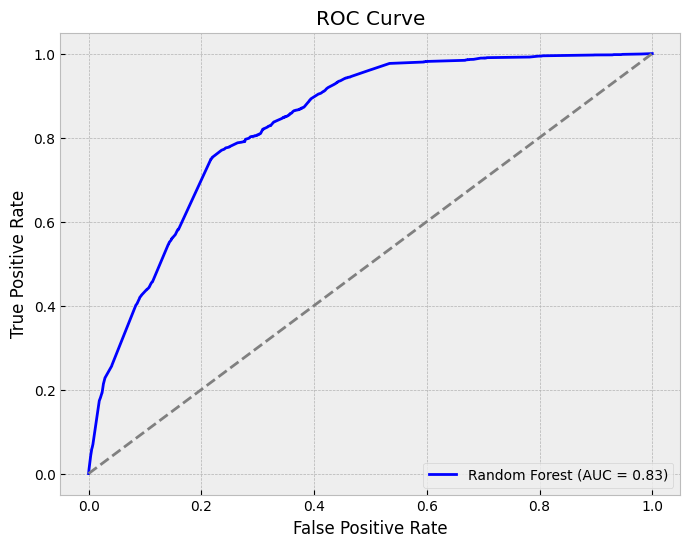

In [352]:
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [353]:
preds_df["predicted_label"] = (predicted_probs >= 0.5).astype(int)

accuracy = accuracy_score(true_labels, preds_df["predicted_label"])
precision = precision_score(true_labels, preds_df["predicted_label"])
recall = recall_score(true_labels, preds_df["predicted_label"])
f1 = f1_score(true_labels, preds_df["predicted_label"])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7759
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


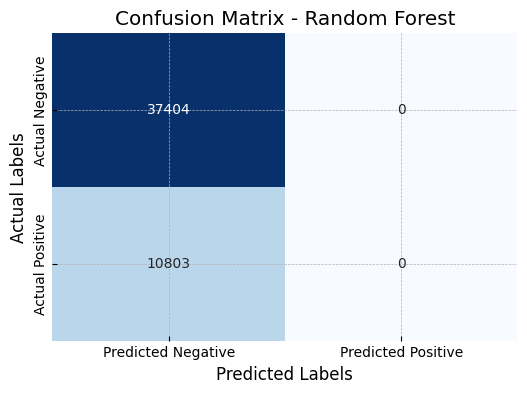

In [354]:
cm = confusion_matrix(preds_df["is_killed"], preds_df["prediction"])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

This might be overfitting we have to see and precision, recall is 0 how?

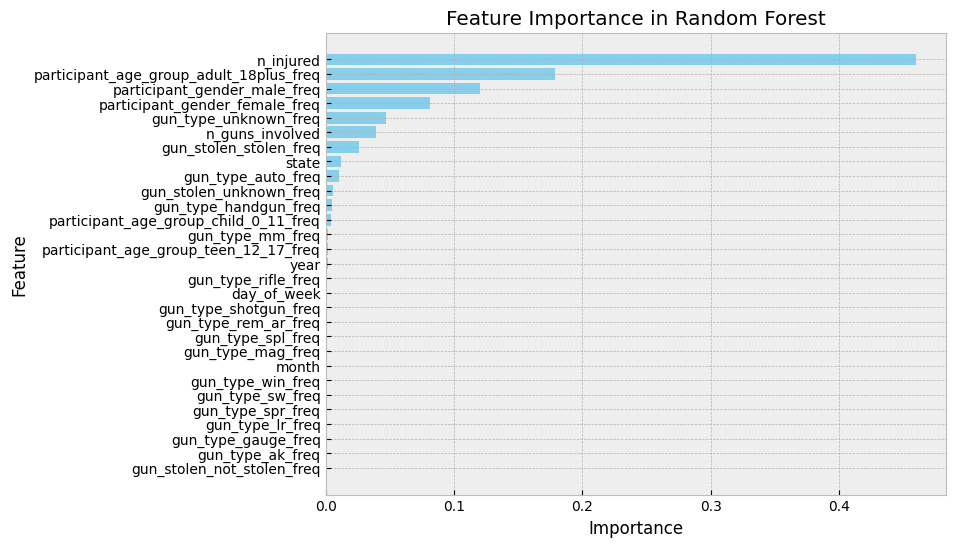

In [356]:
feature_importances = rf_model.featureImportances.toArray()


features_sorted = sorted(zip(feature_importances, feature_columns), reverse=True)
importances, sorted_feature_names = zip(*features_sorted)

plt.figure(figsize=(8, 6))
plt.barh(sorted_feature_names, importances, color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()
plt.show()

##### Gradient Boosting

In [358]:
gbt = GBTClassifier(labelCol="is_killed", featuresCol="features", maxBins=500)

gbt_model = gbt.fit(train_data)
train_predictions_gbt = gbt_model.transform(train_data)
test_predictions_gbt = gbt_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="is_killed", metricName="areaUnderROC")

train_auc_gbt = evaluator.evaluate(train_predictions_gbt)
print(f"Gradient Boosting Train AUC: {train_auc_gbt}")

test_auc_gbt = evaluator.evaluate(test_predictions_gbt)
print(f"Gradient Boosting Test AUC: {test_auc_gbt}")

Gradient Boosting Train AUC: 0.8755501392588025


Gradient Boosting Test AUC: 0.8744285262276735


In [359]:
preds_df_gbt = test_predictions_gbt.select("is_killed", "prediction", "probability").toPandas()

preds_df_gbt["probability"] = preds_df_gbt["probability"].apply(lambda x: x[1])
true_labels_gbt = preds_df_gbt["is_killed"]
predicted_probs_gbt = preds_df_gbt["probability"]

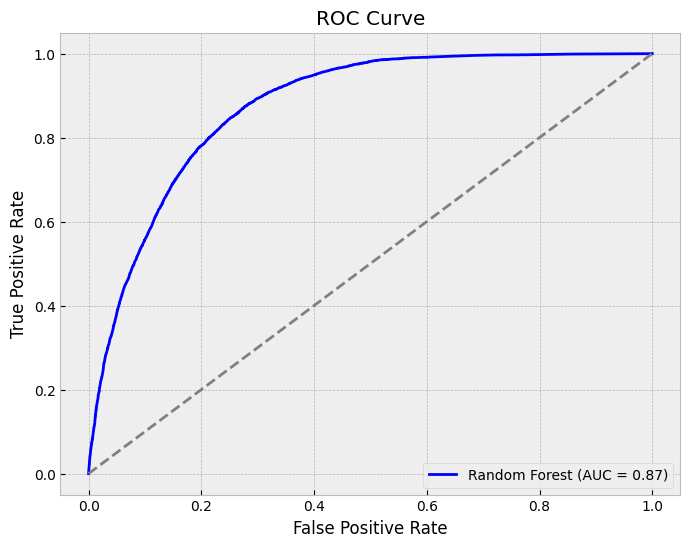

In [360]:
fpr, tpr, thresholds = roc_curve(true_labels_gbt, predicted_probs_gbt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

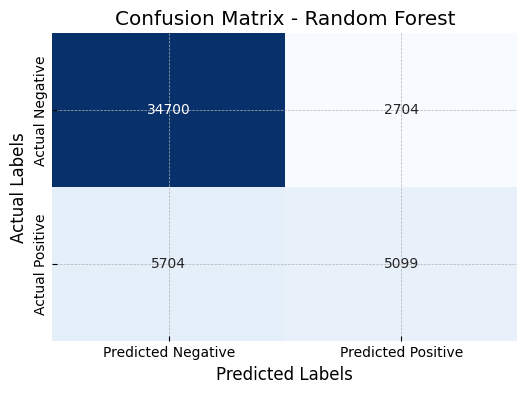

In [361]:
cm = confusion_matrix(preds_df_gbt["is_killed"], preds_df_gbt["prediction"])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix - Random Forest")
plt.show()

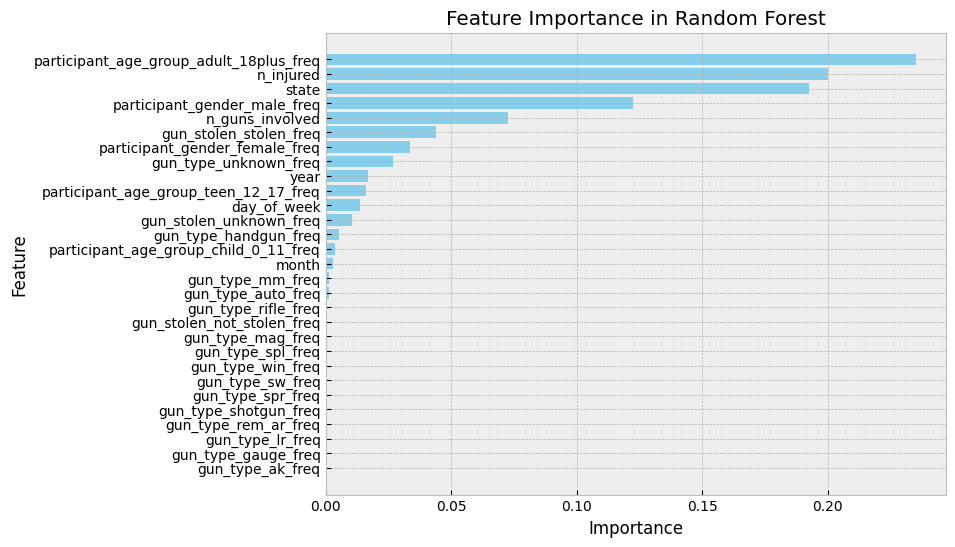

In [362]:
feature_importances = gbt_model.featureImportances.toArray()


features_sorted = sorted(zip(feature_importances, feature_columns), reverse=True)
importances, sorted_feature_names = zip(*features_sorted)

plt.figure(figsize=(8, 6))
plt.barh(sorted_feature_names, importances, color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()
plt.show()

Both of them seem to take a lot of weightage from the particpant status columns which is really missleading too, so we will drop and re train the model.

We can create a mass_shooting column based on `incident_characteristics`.